<a href="https://colab.research.google.com/github/SIDIBEMoussa/Tanzania-Tourism-Prediction/blob/main/Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [386]:
import warnings
warnings.filterwarnings('ignore')

In [387]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [388]:
train_path = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/Train.csv"
test_path = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/Test.csv"
sub_data = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/SampleSubmission.csv"

In [389]:
train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)
sub_set = pd.read_csv(sub_data)

In [390]:
train_set.head(3)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0


In [391]:
def countplot(df,col):
    # Trier le DataFrame par la colonne spécifiée en ordre décroissant de fréquence
    order = df[col].value_counts().index

    plt.rcParams["font.size"] = 6
    plt.figure(figsize=(13,5))

    # Utiliser l'argument 'order' pour spécifier l'ordre des barres
    sns.countplot(x=df[col], order=order)

    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=90)
    plt.show()

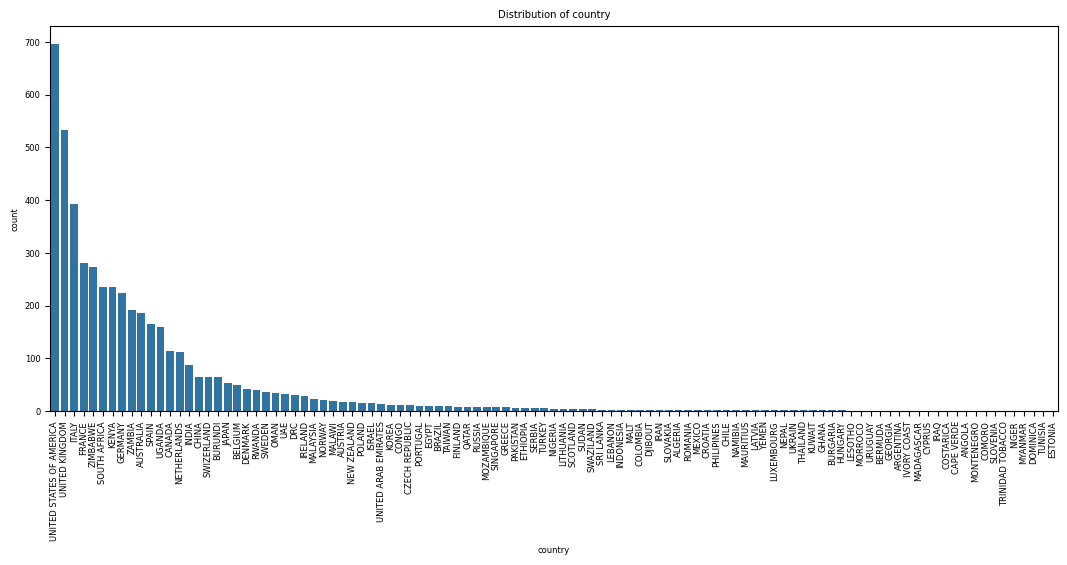

In [392]:
countplot(train_set,"country")

<Axes: ylabel='Density'>

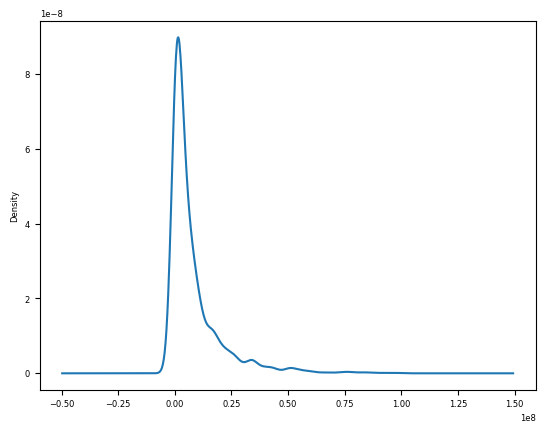

In [393]:
train_set["total_cost"].plot(kind="kde")

In [394]:
cate_cols = train_set.select_dtypes(include="object").columns
train_set[cate_cols] = train_set[cate_cols].astype("category")
test_set[cate_cols] = test_set[cate_cols].astype("category")

In [395]:
train_set.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [396]:
X = train_set.drop(["total_cost"],axis=1)
y = train_set["total_cost"]
X_to_fill = pd.concat([X,test_set],axis=0)
X_to_fill = X_to_fill.set_index("ID")

In [397]:
def binary_cat(df):
    cols = []
    for col in df:
        if df[col].nunique() == 2:
            cols.append(col)
    return cols

In [398]:
freq_cols = ["country"]
coded_cols = ['night_mainland', 'night_zanzibar']
one_hot_cols = ["age_group","purpose","main_activity","info_source","payment_mode"]
nan_cols = train_set.columns[train_set.isna().any()].tolist()
binary_cols = binary_cat(X_to_fill)

all_select_cols = freq_cols+coded_cols+one_hot_cols+nan_cols+binary_cols

assert X_to_fill.shape[1] == len(all_select_cols)

In [399]:
X_to_fill.loc[X_to_fill[nan_cols[1]] > 7, nan_cols[1]] = np.nan
X_to_fill.loc[X_to_fill[nan_cols[2]] > 6, nan_cols[2]] = np.nan

In [400]:
frequency_map = X_to_fill["country"].value_counts(normalize=True).to_dict()
X_to_fill["country"] = X_to_fill["country"].map(frequency_map)
# Dummies coding
X_to_fill = pd.get_dummies(X_to_fill,columns=one_hot_cols,drop_first=True,dtype=int)
#Binary coding
for col in binary_cols:
    categories = X_to_fill[col].unique()
    X_to_fill[col] = X_to_fill[col].map({categories[0]:1,categories[1]:0})


travel_with_dict = {'Alone':1,'Children':2,'Friends/Relatives':3,'Spouse':4,'Spouse and Children':5}
X_to_fill["travel_with"] = X_to_fill["travel_with"].map(travel_with_dict)

impression_dict = {'Satisfies and Hope Come Back': 7,
                   'Excellent Experience': 6,
                   'Wonderful Country, Landscape, Nature': 5,
                   'Good service': 4,
                   'Friendly People': 3,
                   'Wildlife': 2,
                   'No comments': 1}
X_to_fill["most_impressing"] = X_to_fill["most_impressing"].map(impression_dict)

In [401]:
def separate_nan_rows(df,col):
    """Sépare les lignes avec NaN et non-NaN dans un DataFrame pandas.

    Args:
        df: Le DataFrame pandas.

    Returns:
        Un tuple contenant deux DataFrames : le premier avec les lignes contenant des NaN,
        et le second avec les lignes ne contenant pas de NaN.
    """
    nan_rows = df[df[col].isnull()]
    not_nan_rows = df[df[col].notnull()]
    return not_nan_rows,nan_rows

In [407]:
from sklearn.ensemble import RandomForestClassifier

X_nan = X_to_fill[nan_cols]
X_not_nan = X_to_fill.drop(columns=nan_cols)

for col in nan_cols:
    X_not_nan[col] = X_nan[col]
    X_train,X_test = separate_nan_rows(X_not_nan,col)
    imputer_model = RandomForestClassifier(n_estimators=300, max_depth=7,random_state=42)
    imputer_model.fit(X_train.drop(columns=[col]),X_train[col])
    X_test[col] = imputer_model.predict(X_test.drop(columns=[col]))
    X_not_nan = pd.concat([X_train,X_test])

assert X_to_fill.shape == X_not_nan.shape
X_to_fill = X_not_nan

In [408]:
X_not_nan[nan_cols[3]].value_counts()

,count
most_impressing,
3.0,3864
1.0,1012
5.0,675
4.0,470
6.0,350
7.0,39


In [409]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer,SimpleImputer

#imputer = IterativeImputer(max_iter=20, random_state=42)
#X_to_fill_imputed = pd.DataFrame(imputer.fit_transform(X_to_fill),columns=X_to_fill.columns,index=X_to_fill.index)

In [410]:
X_to_fill.head(3)

,country,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,...,"info_source_Travel, agent, tour operator",info_source_inflight magazines,info_source_others,payment_mode_Credit Card,payment_mode_Other,payment_mode_Travellers Cheque,travel_with,total_female,total_male,most_impressing
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,0.014041,1,1,1,1,1,1,1,1,13.0,...,0,0,0,0,0,0,3,1.0,1.0,3.0
tour_1000,0.109672,1,1,1,1,1,1,1,1,1.0,...,0,0,0,0,0,0,1,0.0,1.0,6.0
tour_1002,0.109672,0,1,0,0,0,0,0,1,11.0,...,1,0,0,0,0,0,4,1.0,1.0,3.0


In [411]:
#for col in nan_cols:
#    X_to_fill_imputed[col] = X_to_fill_imputed[col].round()

In [412]:
#X_to_fill_imputed = X_to_fill_imputed[X_to_fill_imputed[nan_cols[2]]<8]
#X_to_fill_imputed = X_to_fill_imputed[X_to_fill_imputed[nan_cols[1]]<8]

In [413]:
X_to_fill["travel_with"] = X_to_fill["travel_with"].astype("category")
X_to_fill = pd.get_dummies(X_to_fill,columns=["travel_with"],dtype=int)

In [414]:
df_filled = X_to_fill

In [415]:
train_data = df_filled.loc[train_set.ID]
test_data = df_filled.loc[test_set.ID]

In [416]:
train_data.head(3)

,country,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,...,payment_mode_Other,payment_mode_Travellers Cheque,total_female,total_male,most_impressing,travel_with_1,travel_with_2,travel_with_3,travel_with_4,travel_with_5
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,0.014041,1,1,1,1,1,1,1,1,13.0,...,0,0,1.0,1.0,3.0,0,0,1,0,0
tour_10,0.109672,1,1,1,1,1,1,1,1,14.0,...,0,0,1.0,0.0,5.0,0,0,1,0,0
tour_1000,0.109672,1,1,1,1,1,1,1,1,1.0,...,0,0,0.0,1.0,6.0,1,0,0,0,0


<Axes: ylabel='Density'>

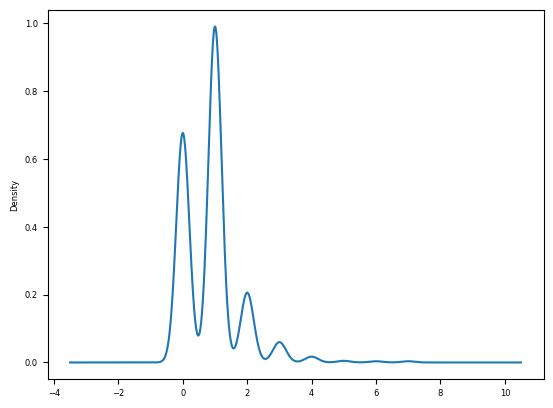

In [417]:
test_data[nan_cols[1]].plot(kind="kde")

In [418]:
import numpy as np
from scipy import stats

def box_cox_shifted(data):
  """
  Applies the Box-Cox transformation with data shifting and optimal lambda selection.

  Args:
    data: A NumPy array or pandas Series containing the data to transform.

  Returns:
    A tuple containing:
      - transformed_data: The transformed data.
      - lambda_value: The optimal lambda value used for the transformation.
  """
  data_shifted = data + abs(data.min()) + 1  # Shift data to be positive
  transformed_data, lambda_value = stats.boxcox(data_shifted)
  return transformed_data, lambda_value

In [419]:
train_data["total_spend"] = y.values

In [420]:
train_data.iloc[:,10:20].head(3)

,night_zanzibar,first_trip_tz,age_group_24-Jan,age_group_25-44,age_group_45-64,age_group_65+,purpose_Leisure and Holidays,purpose_Meetings and Conference,purpose_Other,purpose_Scientific and Academic
ID,,,,,,,,,,
tour_0,0.0,1,0,0,1,0,1,0,0,0
tour_10,7.0,0,0,1,0,0,1,0,0,0
tour_1000,31.0,1,0,1,0,0,0,0,0,0


In [421]:
train_data['night_mainland_log'] = np.log(1+train_data['night_mainland'])
train_data['night_zanzibar_log'] = np.log(1+train_data['night_zanzibar'])

test_data['night_mainland_log'] = np.log(1+test_data['night_mainland'])
test_data['night_zanzibar_log'] = np.log(1+test_data['night_zanzibar'])

# Modélisation

In [422]:
from sklearn.ensemble import RandomForestRegressor

In [423]:
X,y = train_data.drop(columns=["total_spend"]),train_data["total_spend"]

In [424]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.15,random_state=42)

In [425]:
rf = RandomForestRegressor(n_estimators=300,max_depth=15,max_features='sqrt')
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300)

In [426]:
y_ori_predict = rf.predict(X_train)
print(f"Mean absolute error:{mean_absolute_error(y_train,y_ori_predict)}")

Mean absolute error:2823259.6768583283


Mean absolute error:4747133.301312126

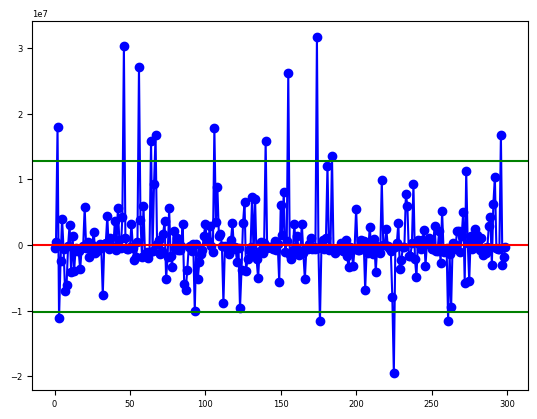

In [427]:
from scipy.stats import median_abs_deviation

residus_ori = y_train - y_ori_predict
#residus = y_test - y_pred
med = np.median(residus_ori)
# as the name it helps to detection outliers
mad = median_abs_deviation(residus_ori)
z_mad = np.abs((residus_ori- med) / mad)
std = np.std(residus_ori)

nbre_point = 300 #len(y_train)
plt.plot(range(nbre_point),residus_ori[:nbre_point], "bo-")
plt.axhline(np.mean(residus_ori),color="red")
plt.axhline(np.mean(residus_ori)+2.5*std,color="green")
plt.axhline(np.mean(residus_ori)-2*std,color="green")
plt.show()

In [428]:
from scipy.stats import median_abs_deviation
def filtrage_data(model, X_train, y_train):

    predictions_train = model.predict(X_train)
    residuals_train = y_train - predictions_train
    # Median des residus
    med = np.median(residuals_train)
    # as the name it helps to detection outliers
    mad = median_abs_deviation(residuals_train)
    z_mad = np.abs((residuals_train- med) / mad)

    moy = np.mean(residuals_train)
    std = np.std(residuals_train)
    # Defining bounds
    upper_bound = moy + 3*std
    lower_bound = moy - 2*std


    # outliers (We take the default threshold for z_mad as 3 but can be improved)
    outliers = np.where((z_mad> 3)| (residuals_train < lower_bound) | (residuals_train> upper_bound))[0]
    # Filter out outliers from the test data
    X_train_filtered = X_train.drop(index=X_train.index[outliers])
    y_train_filtered = y_train.drop(index=y_train.index[outliers])
    print(f"Number of outliers: {len(outliers)/len(y_train):.2%}")
    return X_train_filtered, y_train_filtered

X_filtered, y_filtered = filtrage_data(rf, X_train, y_train)

Number of outliers: 23.68%


# Data filtered

In [429]:
rf_model = RandomForestRegressor(n_estimators=400,max_depth=15,max_features='sqrt')
rf_model.fit(X_filtered,y_filtered)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=400)

In [430]:
y_pred = rf_model.predict(X_test)
print(f"Mean absolute error:{mean_absolute_error(y_test,y_pred)}")

Mean absolute error:4369009.087142141


4362074.1516900575

In [431]:
test_pred = rf_model.predict(test_data)

In [432]:
sub_set["total_cost"] = test_pred

In [433]:
sub_set.to_csv("submission.csv",index=False)